In [1]:
# Sbi
import sbi
from sbi.utils.get_nn_models import likelihood_nn
from sbi.analysis import pairplot
from sbi import inference

# Sbi benchmark
import sbibm
from sbibm.metrics import c2st

# torch and so
import torch
from torch import nn
import numpy as np

import matplotlib.pyplot as plt


In [3]:
# Loads a model...
def get_model(task_name):
    task = sbibm.get_task(task_name) 
    prior = task.prior_dist
    simulator = task.get_simulator()
    observation = task.get_observation(num_observation=1) 

    thetas = prior.sample((10000,))
    xs = simulator(thetas)


    inf = inference.SNLVI(prior)
    density_estimator = inf.append_simulations(thetas, xs).train(max_num_epochs=0)
    state_dict = torch.load(f"likelihood_models/{task_name}.net")
    density_estimator = inf._neural_net
    density_estimator.load_state_dict(state_dict())
    return inf, task

In [4]:
inf_slcp, task = get_model("gaussian_linear")
num_observation = 1
observation = task.get_observation(num_observation=num_observation)

In [18]:
%%time
posterior = inf_slcp.build_posterior(flow="affine_autoregressive", num_flows=3)
posterior.set_default_x(observation)
posterior.train(elbo_particles=64)

Loss: 8.28:  22%|██▏       | 220/1000 [00:04<00:16, 47.32it/s]
Converged with loss 8.279999732971191
Wall time: 4.69 s



![image](figures\mcmc_vi_benchmark.png)

# Two Moons Mode Colapse problem
![image](figures\two_moons_svi.png)

# Variational Inference with Renyi Divergences

The general form of an alpha divergence is given by
$$ D_\alpha(p||q) = \frac{1}{\alpha-1} \log \int p(\theta)^\alpha q(\theta)^{1-\alpha} d\theta$$

Several common divergences are in this family e.g. for $\alpha \rightarrow 1$ we obtian the KL divergence. For $\alpha = 0.5$ the Hellinger distance and for $\alpha=2$ something proportional to the chi square divergence.

We can write the objective as 
$$ \mathcal{L}_\alpha (q) = \frac{1}{1-\alpha} \log \mathbb{E}_q \left[ \left( \frac{p(\theta, x)}{q(\theta)}  \right)^{1-\alpha}\right]$$

Note the log is outside the expectation, hence we have to do it over the ration of densities. Note that this is numerically very unstable. Nontheless we can take stabely estiamte its gradients by
$$ \nabla_\phi \mathcal{L}_\alpha (q_\phi) = \mathbb{E}\left[ w_\alpha \nabla_\phi \log \frac{p(\theta, x)}{q(\theta)} \right]$$ 
with 
$$w_\alpha = \left(\frac{p(\theta, x)}{q(\theta)} \right)^{1-\alpha} / \mathbb{E}\left[\left(\frac{p(\theta, x)}{q(\theta)} \right)^{1-\alpha} \right]$$
Hence it can be interpreted as an importance weighted ELBO particles. We have two cases
* If $\frac{p(\theta, x)}{q(\theta)}$ is large this means that $p(\theta, x) >> q(\theta)$. Hence $q$ does not cover the support of $p$. For $\alpha \rightarrow - \infty$, this elbo particle is weighted very high! Hence induces **support covering** behaviour.
* If $\frac{p(\theta, x)}{q(\theta)}$ is small this means that $p(\theta, x) << q(\theta)$. Hence $q$ does not cover a mode of $p$. For $\alpha \rightarrow  \infty$, this elbo particle is weighted very high! Hence induces **mode seeking** behaviour.

In [32]:
inf, task = get_model("slcp")
num_observation = 1
observation = task.get_observation(num_observation=num_observation)

In [48]:
%%time
posterior = inf.build_posterior(flow="affine_autoregressive", num_flows=10, permute=True)
posterior.set_default_x(observation)
posterior.train(loss="renjey_divergence", n_particles=10000, alpha=0.4)

Loss: 21.67:  37%|███▋      | 370/1000 [01:30<02:33,  4.09it/s]
Converged with loss 21.670000076293945
Wall time: 1min 30s



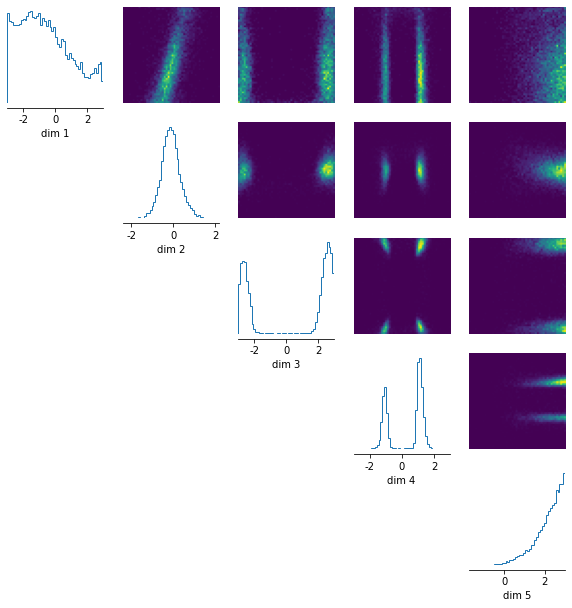

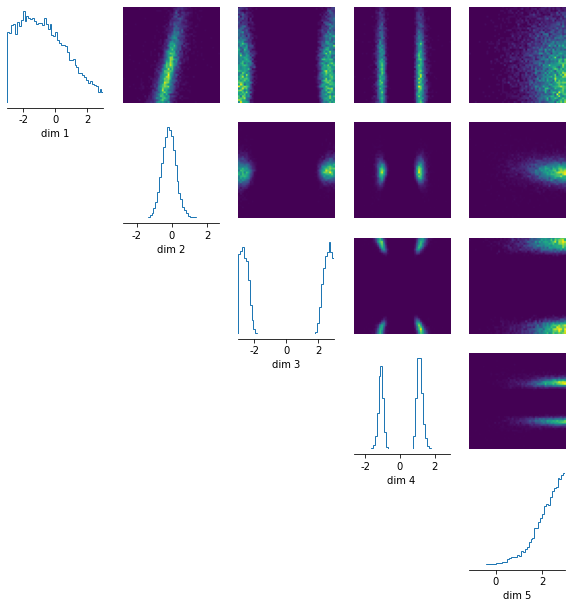

In [373]:
mcmc_samples = np.load("samples/samples_mcmc_slcp.npy")
samples = posterior.sample((10000,))
_ = pairplot(samples, axis=axs[0])
_ = pairplot(mcmc_samples)

![image](figures/iaf_renjey_performance.png)

# Mixture of normalizing flow

We consider the variational family 
$$ q(\theta; \Phi, \pi) = \sum_{k=1}^K \pi_k q(\theta|\phi_k)$$

The KL divergence is given by
\begin{align*}
D_{KL}(q||p) &= \mathbb{E}_q\left[\log \frac{p(x,\theta)}{q(\theta)}\right]\\
&= \int \log \frac{p(x,\theta)}{q(\theta)} \sum_{k=1}^K \pi_k q(\theta|\phi_k) d\theta\\
&= \sum_{k=1}^K \pi_k \int \log \frac{p(x,\theta)}{q(\theta)} q(\theta|\phi_k)d\theta \\
&= \sum_{k=1}^K \pi_k \mathbb{E}_{q_k}\left[\log \frac{p(x,\theta)}{q(\theta)}\right]
\end{align*}
The gradients with respect to $\phi_k$ are given by
$$ \nabla_{\phi_k} D_{KL}(q||p) = \pi_k \nabla_k \mathbb{E}_{q_k}\left[\log \frac{p(x,\theta)}{q(\theta)}\right]$$
This is important as we can reparameterize each component but not the mixture distribution itself.

Note that for $\pi$ there is an constraint that is $\sum_{k=1}^K \pi_k = 1$. Hence we parameterize it as $\pi = softmax(c)$. Then we can update $c$ unconstrained. The gradient with respect to $\pi_k$ is given by:
$$ \nabla_{\pi_l}D_{KL}(q||p) = \nabla{\pi_l}\sum_{k=1}^K \pi_k \mathbb{E}_{q_k}\left[\log \frac{p(x,\theta)}{q(\theta)}\right] $$


In [50]:
inf, task = get_model("two_moons")
num_observation = 1
observation = task.get_observation(num_observation=num_observation)

In [56]:
%%time
posterior = inf.build_posterior(flow="spline_autoregressive", num_comps=2)
posterior.set_default_x(observation)
posterior.train()

Loss: 0.82:  33%|███▎      | 330/1000 [00:46<01:33,  7.17it/s]
Converged with loss 0.8199999928474426
Wall time: 46 s



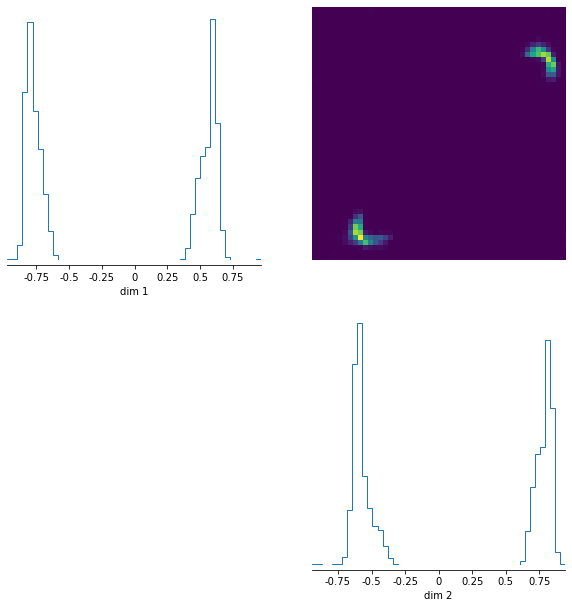

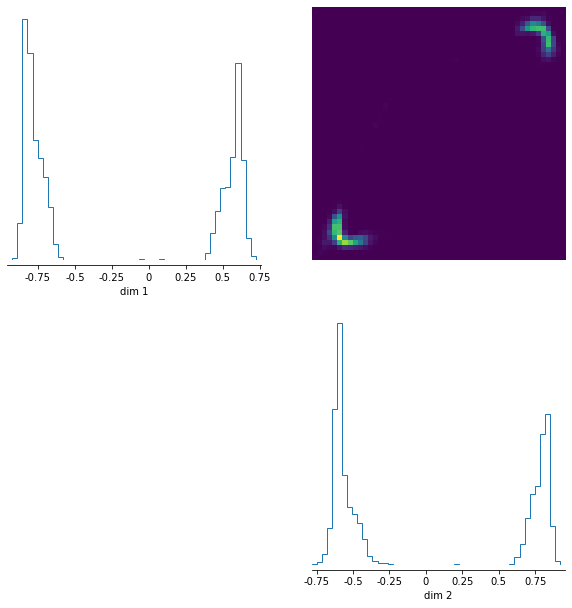

In [57]:
mcmc_samples = np.load("samples/samples_mcmc_two_moons.npy")
samples = posterior.sample((10000,))
_ = pairplot(samples)
_ = pairplot(mcmc_samples)

![image](figures/two_moons_spline_renjey_performance.png)

# Evaluate variational posterior

Recall that if we want to estimate moments from an arbitrary distribution e.g. the posterior $p(\theta|x)$ then we can use importance sampling. Assume we want to estimate $\mathbb{E}_p[f(\theta)]$ then we can do
$$ \mathbb{E}_p[f(\theta)] = \int f(\theta) p(\theta|x)dx \int f(\theta) \frac{p(\theta|x)}{q(\theta)}q(\theta)d\theta = \mathbb{E}_q\left[ f(\theta) \frac{p(\theta|x)}{q(\theta)} \right]$$
Hence we can sample from an arbitrary proposal $\theta_1, \dots, \theta_m \sim q(\theta)$. And compute the **importance weights**
$$ w_i = \frac{p(\theta_i|x)}{q(\theta_i)} = \frac{1}{p(x)} \frac{p(\theta_i,x)}{q(\theta_i)} = \frac{1}{Z} w_i$$
The evidence $Z$ is typically unknown but can be approximated by as 
$$Z = p(x) = \int p(\theta,x)d\theta = \int \frac{p(\theta,x)}{q(\theta)} q(\theta)d\theta = \mathbb{E}_q[\frac{p(\theta|x)}{q(\theta)}] \approx \frac{1}{M}\sum_{i=1}^M w_i = \hat{Z}$$
Hence in total we obtain 
$$\mathbb{E}_p[f(\theta)] = \mathbb{E}_q\left[ f(\theta) \frac{p(\theta|x)}{q(\theta)} \right] \approx \frac{1}{M}\sum_{i=1}^m f(\theta_i) \frac{w_i}{\hat{Z}}$$
The problem is that this suffers from **large variance** if the proposal $q$ differs from the posterior $p(\theta|x)$. Nonetheless instead of an arbitrary simple proposal we can consider the variational posterior $q(\theta; x)$. This should be rather close to the true posterior if everythink worked! Notice if $w_i = 1$ then the estimate becomes $\mathbb{E}_p[f(\theta)] \approx \frac{1}{\hat{Z}}\sum_{i=1}^m f(\theta_i) w_i = \frac{1}{m}\sum_{i=1}^m f(\theta_i) \approx \mathbb{E}_q[f(\theta)]$. Thus $q(\theta) = p(\theta|x)$. Hence this clearly contains information between the dispensary of $q(\theta)$ and $p(\theta|y)$.

Nonetheless if e.g. the pisterior does not cover one of the modes the importance weights may have infinite variance. To compensate this one can use Pareto smoothed Importance sampling. A generaluzed Pareto distribution with shape paramter $k$ and location-scale parameter $\mu, \sigma$ has for $k \neq 0$ density
$$ p(x|\mu,\sigma,k) = \frac{1}{\sigma} \left( 1 + k \left(\frac{x-\mu}{\sigma}\right) \right)^{-1/k -1} $$

We take the $M = min(N/5,3\sqrt(N))$ largest samples of $r_i$, then estimate the shape paramter $\hat{k}$ and repalce the M largest $r_s$ by their expected value under the generalized Pareto distribution. The other weights remian unchanged but are truncated by $max(r_s)$. We can estiamte $k$ by some method e.g. maximum likelihood.

The fitted shape paramter $\hat{k}$, turns out to provid a **diagnostic measurement**. Notice that a generalized pareto distribution with shape $k$ has **finite moments up to order $\frac{1}{k}$**. Hence any positive $k$ can be viewed as estimate to $k = \inf\left\{k' > |\mathbb{E}_q\left[\frac{p(\theta|x)}{q(\theta)} \right]^{1/k'} < \infty\right\}$ or after a log transformation
$$ k = \inf\{k' > 0 | D_{1/k'}(p||q) < \infty\}$$
where $D_{1/k'}$ is a alpha divergence. Typically:
* if $\hat{k} < 0.5$ then the variational approximation is good.
* if $0.5 < \hat{k} < 0.7$ the it is ok, but imporvable.
* if $\hat{k} > 0.7$ then the variational posterior is a rather bad approximation.


In [6]:
from sbi.vi.paretto_smoothed_is import gpdfit

In [32]:
inf, task = get_model("slcp")
num_observation = 1
observation = task.get_observation(num_observation=num_observation)

In [33]:
posterior_good = inf.build_posterior(flow="affine_autoregressive")
posterior_good.set_default_x(observation)
posterior_good.train()

Loss: 22.79:  66%|██████▌   | 660/1000 [00:16<00:08, 40.34it/s]
Converged with loss 22.790000915527344



In [38]:
posterior_bad = inf.build_posterior(flow="affine_autoregressive")
posterior_bad.set_default_x(observation)
posterior_bad.train(max_num_iters=20)

Loss: 157.48: 100%|██████████| 20/20 [00:00<00:00, 42.05it/s]


In [35]:
def evaluate(posterior, N = int(1e5)):
    M = int(min(N/5,3*np.sqrt(N)))
    logweights = posterior._optimizer.generate_elbo_particles(observation, N)
    logweights_max = logweights.max()
    weights = torch.exp(logweights-logweights_max)
    vals, _ = weights.sort()
    largest_weigths = vals[-M:]
    mu = vals[-M]
    k, sigma = gpdfit(largest_weigths)
    return mu, k, sigma

In [40]:
_, k, _ = evaluate(posterior_good)
print(k)

tensor(0.0773, grad_fn=<AddBackward0>)


In [43]:
_, k, _ = evaluate(posterior_bad)
print(k)

tensor(1.4200, grad_fn=<AddBackward0>)
